In [1]:
import numpy as np 
import scipy.optimize
import matplotlib.pyplot as plt
import copy

In [2]:
# Material properties
# YM: Young's Modulus [N/mm²]
# v: Poisson's ratio
# sigma_y: initial yield limit [N/mm²]
Young_Mod, v, sigma_y = 1e5, 0, 500

E = (Young_Mod/(1-v**2))*np.array([[1, v, 0],
                                   [v, 1, 0],
                                   [0, 0, (1-v)/2] ])

## Isotropic hardening
# Q_iso: Isotropic asymptote [N/mm²]
# n_iso: exponent 
# b_iso: growth rate
# D_iso: limit [N/mm²]
Q_iso, n_iso, b_iso, D_iso = 80, 3, 10, 170

## Kinematic hardening
# Q_kin = Kinematic asymptote [N/mm²]
# b_kin: growth rate
Q_kin, b_kin = 70, 30

M = np.array([[1, -0.5, 0],
              [-0.5, 1, 0],
              [0, 0, 3] ])
              
# strain rate vector
strain_rate = np.array([[1e-4],
                        [0],
                        [0] ])

# maximum displace in x direction [m]
u_x_max = 1.2e-2

# inital length of bar [m]
l_0 = 2

time_to_u_x_max = u_x_max/(strain_rate[0]*l_0)

In [3]:
def strain(t):
    return strain_rate*t if t < time_to_u_x_max else np.array([[u_x_max/l_0],[0],[0]])

In [4]:
def func_strain_rate(t):
    return strain_rate if t < time_to_u_x_max else np.zeros((3,1))

In [5]:
def equivalent_stress(sigma, backstress):

    sigma_xx = sigma[0] - backstress[0]
    sigma_yy = sigma[1] - backstress[1]
    sigma_xy = sigma[2] - backstress[2]

    return np.sqrt(sigma_xx**2 - sigma_xx*sigma_yy + sigma_yy**2 + 3*sigma_xy**2)

In [6]:
def sigma_macaulay(sigma, backstress, K, power):

    sigma_ex = equivalent_stress(sigma, backstress) - (sigma_y + K)

    return (sigma_ex/D_iso)**power if sigma_ex > 0 else 0

# Implicit scheme 

$\left[\begin{array}{c}
\boldsymbol{F} \\
g\\
\boldsymbol{H} \end{array}\right] =
\left[\begin{array}{c}
\boldsymbol{\varepsilon}_{i+1} - \boldsymbol{\varepsilon}_{i} - \Delta t \cdot\left\{\boldsymbol{E}^{-1} \cdot \big( \frac{\boldsymbol{\sigma}_{i+1}-\boldsymbol{\sigma}_{i}}{\Delta t}\big )+\frac{1}{\sigma_{v, i+1}} \cdot\left\langle\frac{\sigma_{e x, i+1}}{D}\right\rangle^{n} \cdot \dot{\boldsymbol{\varepsilon}}_{0} \cdot \boldsymbol{M} \cdot (\boldsymbol{\sigma}_{i+1} - \boldsymbol{X}_{i+1})\right\} \\
K_{i+1}-K_{i}-\Delta t \cdot b_{iso} \cdot\left(Q_{iso}-K_{i+1}\right) \cdot\left\langle\frac{\sigma_{e x, i+1}}{D}\right\rangle^{n} \\
\boldsymbol{X}_{i+1} - \boldsymbol{X}_{i} - \Delta t \cdot b_{kin} \cdot \Big (\frac{2}{3} Q_{kin} \cdot \frac{1}{\sigma_{v, i+1}} \boldsymbol{M} \cdot (\boldsymbol{\sigma}_{i+1} - \boldsymbol{X}_{i+1}) - \boldsymbol{X}_{i+1} \Big) \cdot \left\langle\frac{\sigma_{e x, i+1}}{D}\right\rangle^{n} 
\end{array}\right]$

In [7]:
def system_of_functions(Z, delta_t, sigma_i, t0, K_i, back_stress_i):

    sigma_i_plus_1 = Z[0:3].reshape([-1,1])
    K_i_plus_1 = Z[3]
    X_i_plus_1 = Z[4:].reshape([-1,1])

    # Plane stress
    fa = strain(t0 + delta_t) - strain(t0) # [3,1]
    fb = np.linalg.inv(E) @ ((sigma_i_plus_1-sigma_i)/delta_t) # [3,1]
    fc = 1/equivalent_stress(sigma_i_plus_1, X_i_plus_1) # [scalar]
    fd = sigma_macaulay(sigma_i_plus_1, X_i_plus_1, K_i_plus_1, n_iso) # [scalar]
    fe = M @ (sigma_i_plus_1 - X_i_plus_1) # [3,1]

    F = fa - delta_t * (fb + fc * fd * fe)

    g = K_i_plus_1 - K_i - delta_t * b_iso * (Q_iso - K_i_plus_1) * fd

    H = X_i_plus_1 - back_stress_i - delta_t * b_kin * ( (2/3) * Q_kin * fc * fe - X_i_plus_1) * fd

    return np.append(np.append(F,g),H)

In [8]:
def fd_plus_jac(Z_prime, delta_t, sigma_i, t0, K_i, X_i):

    sigma_i_plus_1 = Z_prime[0:3].reshape([-1,1]) # [3,1]
    K_i_plus_1 = Z_prime[3]
    X_i_plus_1 = Z_prime[4:].reshape([-1,1]) # [3,1]

    ## common terms

    # functions 
    fc = 1/equivalent_stress(sigma_i_plus_1, X_i_plus_1) # [scalar]
    fd = sigma_macaulay(sigma_i_plus_1, X_i_plus_1, K_i_plus_1, n_iso) # [scalar]
    fe = M @ (sigma_i_plus_1 - X_i_plus_1) # [3,1]

    # derivatives with FD
    dsigmaMac_dsigmaex = n_iso * (1/D_iso) * sigma_macaulay(sigma_i_plus_1, X_i_plus_1, K_i_plus_1, n_iso-1) #[scalar]

    # derivatives wrt K
    dsigmaex_dK = -1 # [scalar]
    dfd_dK = dsigmaMac_dsigmaex * dsigmaex_dK # [scalar]

    # direct derivatives
    dsigmav_dsigma = fc * copy.deepcopy(fe).T #[1,3]
    dfc_dsigma = - (fc**2) * copy.deepcopy(dsigmav_dsigma) #[1,3]
    dsigmaex_dsigma = copy.deepcopy(dsigmav_dsigma) #[1,3]
    dfd_dsigma = dsigmaMac_dsigmaex * dsigmaex_dsigma #[1,3]
    dfe_dsigma = copy.deepcopy(M).T #[3,3]

    dsigmav_dX = - copy.deepcopy(dsigmav_dsigma) #[1,3]
    dfc_dX = - (fc**2) * copy.deepcopy(dsigmav_dX) #[1,3]
    dsigmaex_dX = copy.deepcopy(dsigmav_dX) #[1,3]
    dfd_dX = dsigmaMac_dsigmaex * dsigmaex_dX #[1,3]
    dfe_dX = - copy.deepcopy(M).T #[3,3]

    # Jacobian Assembly
    J = np.zeros((7,7))

    # derivatives of vector function F
    
    # [3,3]
    J[0:3, 0:3] = - delta_t* ( (1/delta_t) * np.linalg.inv(E) + \
                                fc * fd * dfe_dsigma + \
                                fd * fe @ dfc_dsigma + \
                                fc * fe @ dfd_dsigma)
    # [3,1]
    J[0:3, 3:4] = - delta_t * fc * dfd_dK * fe
    
    # [3,3]
    J[0:3, 4:] = - delta_t*(fc * fd * dfe_dX + \
                            fd * fe @ dfc_dX + \
                            fc * fe @ dfd_dX )


    # derivatives of scalar function g

    # [1,3]
    J[3, 0:3]  = - delta_t * b_iso * (Q_iso - K_i_plus_1) * dfd_dsigma

    # [1,1]
    J[3, 3] = 1 - delta_t * b_iso * (-1*fd + (Q_iso - K_i_plus_1) * dfd_dK)

    # [1,3]
    J[3, 4:] = - delta_t * b_iso * (Q_iso - K_i_plus_1) * dfd_dX


    # derivatives of vector function H

    # [3,3]
    J[4:, 0:3] = - delta_t * b_kin * \
                  ( ((2/3) * Q_kin * fc * fe - X_i_plus_1) @ dfd_dsigma + \
                    (2/3) * Q_kin * (fe @ dfc_dsigma + fc * dfe_dsigma) * fd)

    # [3,1]
    J[4:, 3:4] = - delta_t * b_kin * ( (2/3) * Q_kin * fc * fe - X_i_plus_1) * dfd_dK

    # [3,3]
    J[4:, 4:] = np.eye(3) - \
               delta_t * b_kin * \
              ( ((2/3) * Q_kin * fc * fe - X_i_plus_1) @ dfd_dX + \
                ((2/3) * Q_kin * fe @ dfc_dX +  (2/3) * Q_kin * fc * dfe_dX - np.eye(3)) * fd)

    return J

In [9]:
# time integration from 0 to 100s
t_min = 0
t_max = 100
delta_t = 1
N = int((t_max-t_min)/delta_t)
T = np.linspace(t_min,t_max,N+1)

# initialise variables
t_0 = 0
K_0 = 0
x0 = np.append(np.ones((4,1)),np.zeros((3,1)))
sigma_0 = np.ones((3,1))*1e-15
back_stress_0 = np.zeros((sigma_0.shape))
parameters = (delta_t, sigma_0, t_0, K_0, back_stress_0)

store_values = np.zeros((N+1,2))

for i in range(N):

    answer = scipy.optimize.root(system_of_functions, x0, jac=fd_plus_jac, args = parameters, method='lm',
                                options={'col_deriv': 0, 
                                        'xtol': 4e-8, 
                                        'ftol': 4e-8, 
                                        'gtol': 0.0, 
                                        'maxiter': 0, 
                                        'eps': 0.0, 
                                        'factor': 1, 
                                        'diag': None})

    # update parameters
    sigma_i = answer.x[0:3].reshape([-1,1])
    K_i = answer.x[3]
    back_stress_i = answer.x[4:].reshape([-1,1])
    t_i = t_0 + (i+1)*delta_t # previous time step
    parameters = (delta_t, sigma_i, t_i, K_i, back_stress_i)

    # guess for starting point for root finding algorithm using explicit scheme
    sigma_i_guess = sigma_i + delta_t * E @  \
                    (func_strain_rate(t_i)- (1/equivalent_stress(sigma_i, back_stress_i)) * \
                    sigma_macaulay(sigma_i, back_stress_i, K_i, n_iso) \
                    * M @ (sigma_i - back_stress_i))

    K_i_guess = K_i + delta_t * b_iso * (Q_iso-K_i) * sigma_macaulay(sigma_i, back_stress_i, K_i, n_iso)

    back_stress_i_guess = back_stress_i + delta_t * b_kin * \
                ( (2/3) * Q_kin * (1/equivalent_stress(sigma_i, back_stress_i))* M @ \
                    (sigma_i - back_stress_i) - back_stress_i) * sigma_macaulay(sigma_i, back_stress_i, K_i, n_iso)

    # stacking initial point guess sef
    solver_starting_point = np.hstack((sigma_i_guess.flatten(), K_i_guess, back_stress_i_guess.flatten()))


    # store equivalent stress and isotropic hardening
    store_values[i+1, 0] = equivalent_stress(sigma_i, back_stress_i)
    store_values[i+1, 1] = K_i

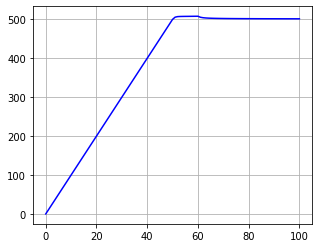

In [10]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(T, store_values[:,0], color = 'blue')

ax.grid()

plt.show()